In [1]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
import datetime
import importlib
from simulator.magnetic import SimulatorMagnetic
from simulator.models import Client, SimulationAlchemy as Simulation
from tqdm.notebook import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

from relaxation.estimators import relaxation_finder_collision
import logging
import sys, os
from settings import DFS_PATH
from utils.utils import plot_mean_std, delete_dfs, smoothen, concat
from utils.ACfunctions import AC

matplotlib.rcParams["figure.dpi"] = 150
matplotlib.rcParams["axes.grid"] = True
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
client = Client()

In [3]:
def get_subdf(df, t, wide, zero_index=True, sp=1):
    df1 = df.loc[t-wide/2:t+wide/2:sp]
    if zero_index:
        df1.set_index(df1.index - df1.index[0], inplace=True)
    return df1

In [ ]:
%%timeit
get_subdf(df_L, 100000, 50000, zero_index=True,sp=10);

In [5]:
def y(x):
    Pi = np.pi
    ArcCot = lambda x : np.arctan(1/x)
    ArcTan = np.arctan
    Sqrt = np.sqrt
    
    return (-Pi/2 + 2*ArcCot((1 + x)/Sqrt(1 - x**2)) + 
     Sqrt(6)*(
         ArcCot(Sqrt(2 + Sqrt(3))*Sqrt((1-x)/(1 + x)) ) 
         - ArcTan(Sqrt((2 - Sqrt(3))*(1 - x)/(1 + x)))
     ) )

In [7]:
items = client.get_simulation_groups(["ER 3.303.weak.lammps"])[:]
[item.load_df() for item in tqdm(items)];

  0%|          | 0/600 [00:00<?, ?it/s]

In [8]:
item = items[0]
dt = item.record_interval
shift = 5000
potential_a = (1/item.a + 1/item.b)/2
eps = (1/item.b - 1/item.a)/2/potential_a
potential_a, eps, item.eccentricity**2/4

(0.20000001305094345, 0.0003612608774673922, 0.000361)

In [9]:
df_L = concat([smoothen(item.df[["L"]],-1).L for item in items])
df_L.set_index(df_L.index-shift, inplace=True)

In [10]:
df_xy = concat([smoothen(item.df[["xy"]],-1).xy for item in items])
df_xy.set_index(df_xy.index-shift, inplace=True)

In [ ]:
df_xx = concat([smoothen(item.df[["xy"]],-1).xy for item in items])
df_xy.set_index(df_xy.index-shift, inplace=True)

In [14]:
df_O = concat([smoothen(item.df[["omega_MLE"]],2*np.pi/potential_a).omega_MLE for item in items])
df_O.set_index(df_O.index-shift, inplace=True)

In [15]:
df_Oraw = concat([smoothen(item.df[["omega_MLE"]],-2*np.pi/potential_a).omega_MLE for item in items])
df_Oraw.set_index(df_Oraw.index-shift, inplace=True)

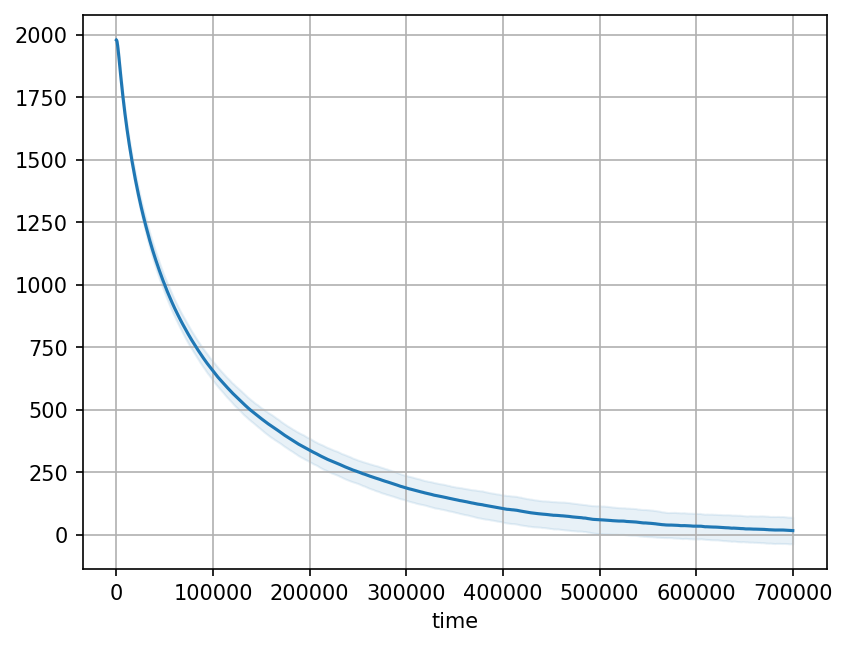

In [16]:
plot_mean_std(df_L.loc[0::100])

In [ ]:
!ll

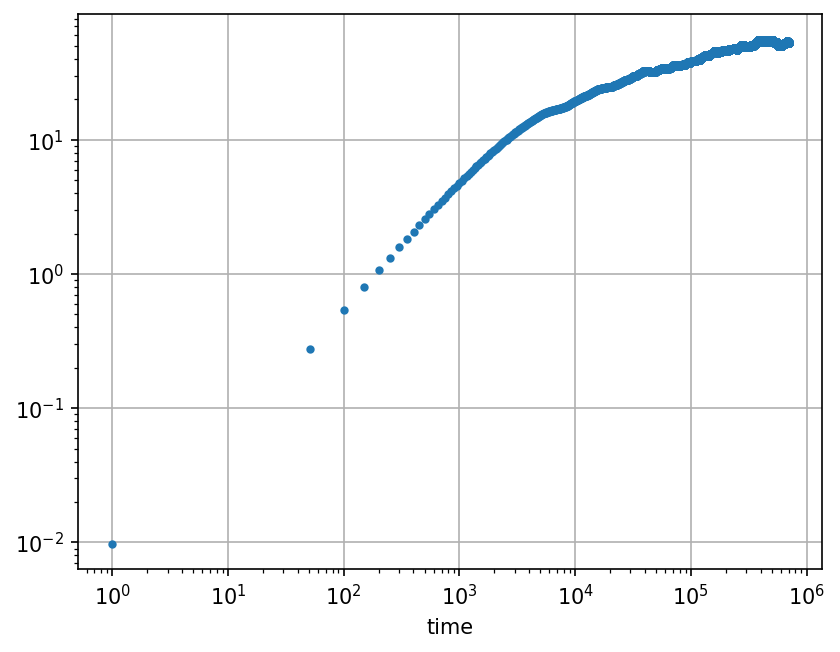

In [50]:
df_L.loc[1::100].std(axis=1).plot(lw=0, marker=".")
plt.yscale("log")
plt.xscale("log")


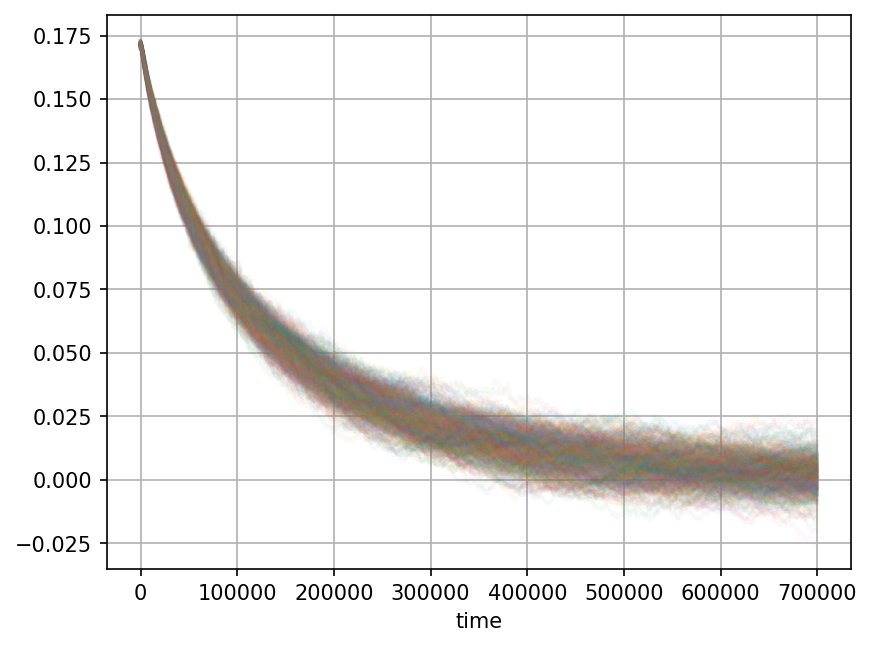

In [39]:
df_O.loc[0::1000].plot(legend=False, alpha=0.05)
plt.grid()

In [230]:
def get_xy(df, wide, n):
    xs, ys = [], []
    for t in tqdm(np.linspace(wide, 700000-wide, n)):
        subdf = get_subdf(df, t, wide).loc[::100]
        vals = subdf.values
        x, y = subdf.index, np.std((vals - vals[0,None,:]), axis=1)
        x, y = x[1:], y[1:]
        filt = (x>4000)
#         filt = (300>x) & (x>50)
            
        slope, a = np.polyfit(np.log(x[filt]), np.log(y[filt]), 1)
        xs.append(t)
        ys.append(slope)
    return xs, ys

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

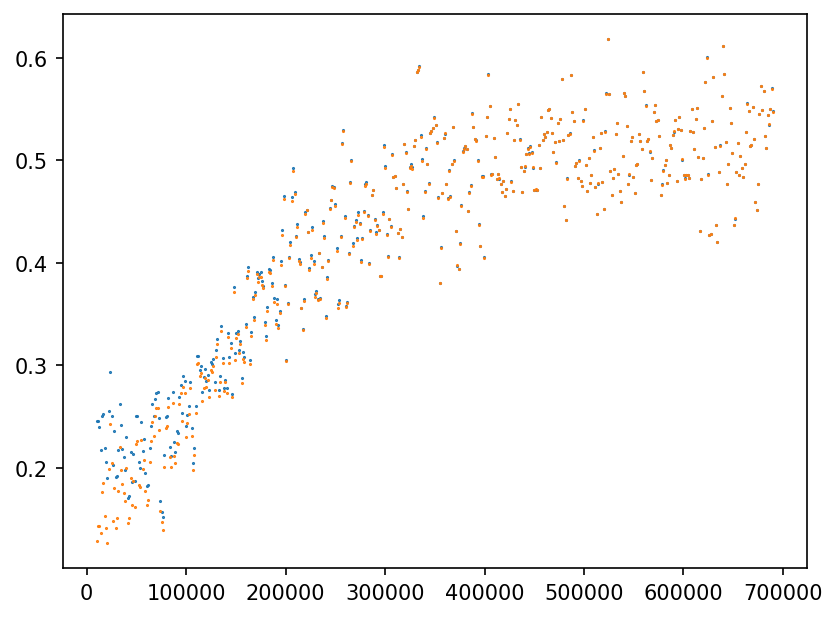

In [243]:
wide=10000
points = 500
plt.plot(*get_xy(df_O, wide,points), ".", ms=1)
plt.plot(*get_xy(df_y, wide,points), ".", ms=1)



plt.grid()

In [162]:
df1 = (df_L.loc[300000:].subtract(df_L.loc[300000], axis=1)).std(axis=1)
df1.set_index(df1.index - df1.index.iloc)

In [181]:
df1.index = (df1.index - df1.index[0])

Slope:  0.4894984023557478


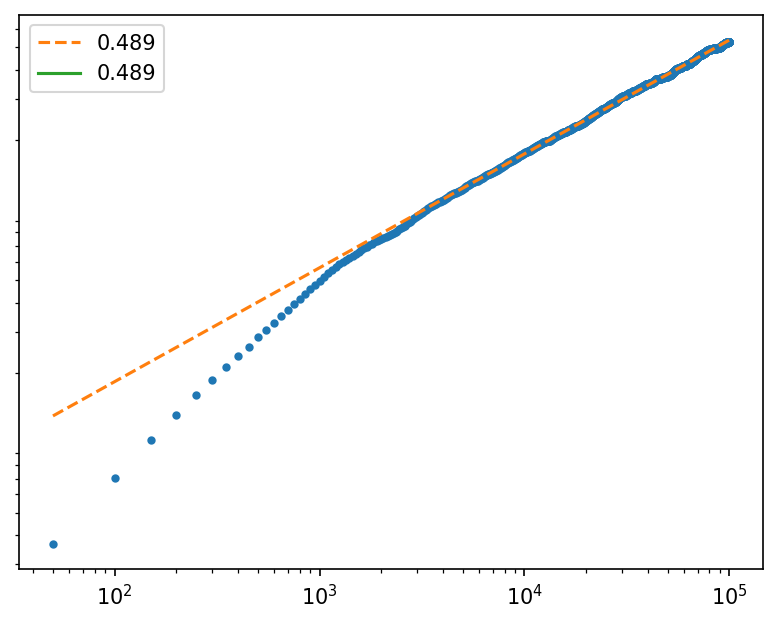

In [236]:
# y = df_xy_cumsum.loc[::1000].std(axis=1).values
df2 = df1.loc[:100000:100]
y = df2.values
x = df2.index.values

x, y = x[1:], y[1:]
plt.plot(x, y, ".")
plt.xscale("log")
plt.yscale("log")
# filt = (300>x) & (x>50)
filt = (x<100000) & (x>2000)
slope, a = np.polyfit(np.log(x[filt]), np.log(y[filt]), 1)
plt.plot(x, np.exp(a+slope*np.log(x)), "--", "k", label=f"{slope:0.3f}")
plt.legend()
print("Slope: ", slope)

In [19]:
df_xy_mean = df_xy.mean(axis=1)

In [20]:
df_xy_mean_smooth = smoothen(df_xy_mean, 2000)

In [21]:
df_xy_dev = df_xy.subtract(df_xy_mean_smooth, axis=0)

In [290]:
vals = df_xy_dev.loc[400000:].dropna().values

acs = [AC(vals[:,k]) for k in tqdm(range(vals.shape[1]))]

acs = np.stack(acs, axis=1)

acs_mean = acs.mean(axis=1)

In [279]:
def Ch_tho(t,gamma, a, T, N):
    return T**2 * np.exp(-gamma* t) * np.cos(a*t)**2 / (a**4 * N)

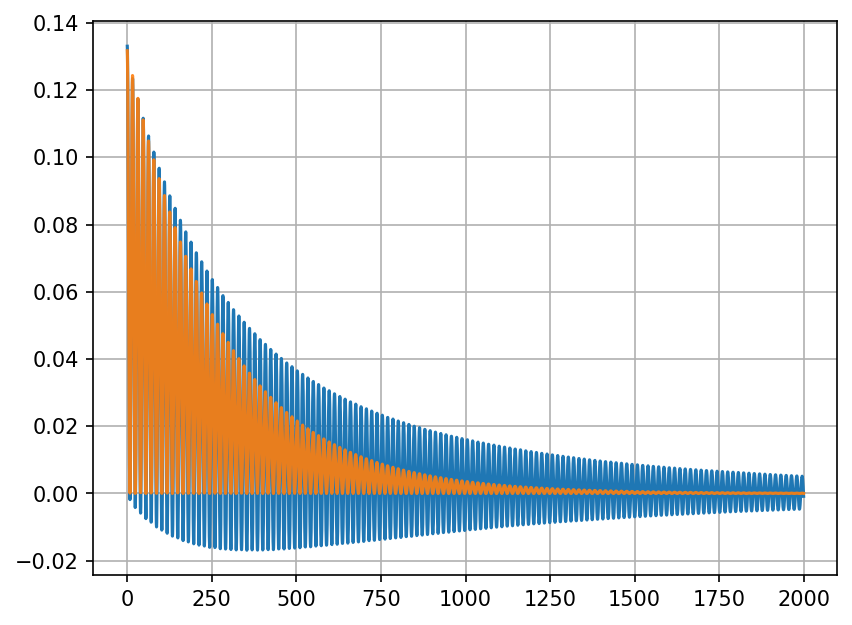

In [286]:
y = acs_mean[:4000]
x = dt * np.arange(len(y))
plt.plot(x, y)
plt.plot(x, Ch_tho(x, 0.0036, 0.2, 0.332, 523), alpha=0.9)

In [22]:
wide = 2000

subdf = get_subdf(df_xy_dev, 10000,wide)
subdf.values.flatten().std()

0.40425669564341776

In [30]:
df_xx = concat([item.df[["xx"]] for item in items]+[item.df[["yy"]] for item in items])
# df_xy.set_index(df_xy.index-shift, inplace=True)

In [32]:
df_xx.set_index(df_xx.index-shift, inplace=True)
df_xx_mean = df_xx.mean(axis=1)

<Axes: xlabel='time'>

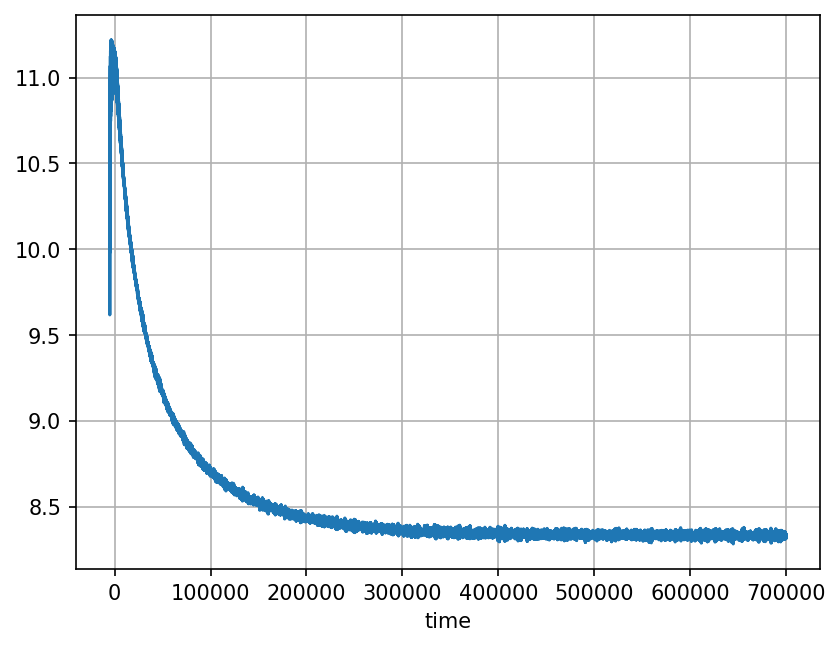

In [34]:
df_xx_mean.plot()

In [38]:
xs, ys = [], []
ys_2 = []

for t in tqdm(np.linspace(30000, 700000-wide, 1000)):
    subdf = get_subdf(df_xy_dev, t, wide)
    vals = subdf.values
    xs.append(t)
    ys.append(vals.var())
    
    ys_2.append(df_xx_mean[t-wide/2:t+wide/2].mean()**2)

  0%|          | 0/1000 [00:00<?, ?it/s]

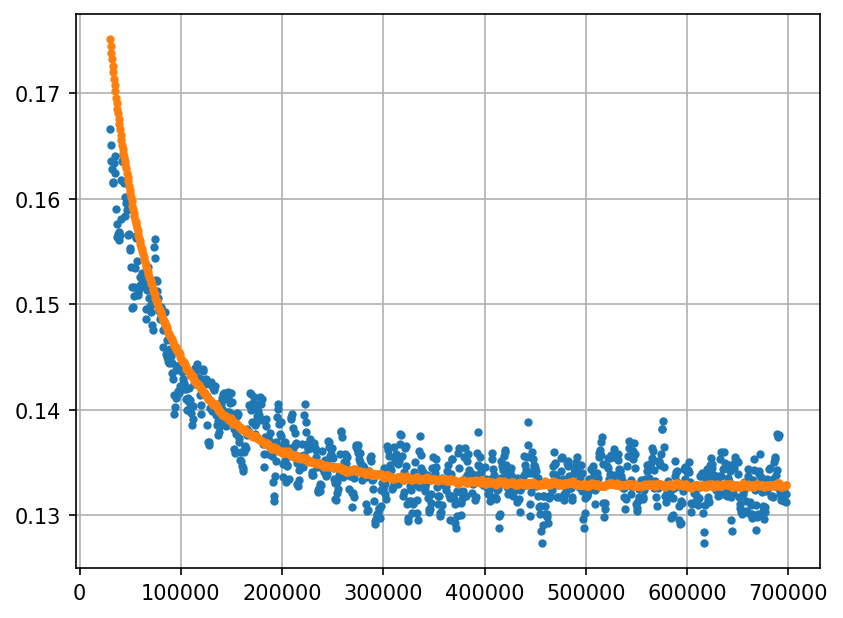

In [40]:
plt.plot(xs, ys,".")
plt.plot(xs, np.array(ys_2)/(item.particles),".")

In [46]:
(3**0.5 * potential_a / item.E_init)**-1

1509.7708429683767

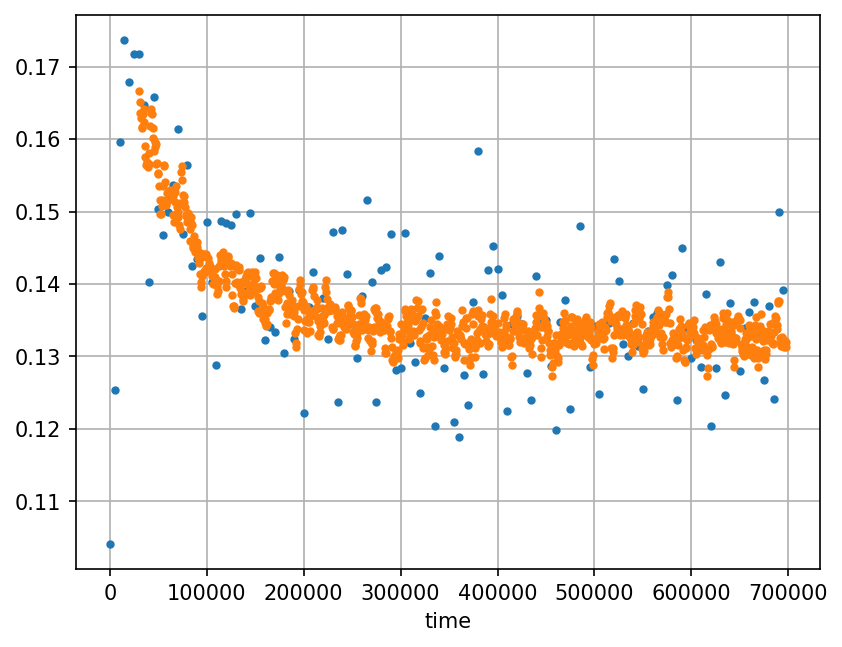

In [26]:

df_xy_dev.loc[::10000].var(axis=1).plot(lw=0, marker=".")
plt.plot(xs, ys,".")